# Car Autoencoder (CIFAR-10)

In [147]:
# import
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, load_model 
from keras.datasets import mnist, cifar10
import random as random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# constants
IMG_SIZE = 32
NUM_CHANNELS = 3

## Training Data

#### Load CIFAR-10 

In [148]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

full_x_train = x_train
full_y_train = y_train

full_x_test = x_test
full_y_test = y_test

# Pixel values go from 0 to 255. 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Images are 32x32x3 -- flatten them. 
img_dims = x_train.shape[1:] 
# x_train = x_train.reshape((len(x_train), np.prod(img_dims)))
# x_test = x_test.reshape((len(x_test), np.prod(img_dims)))

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [149]:
print(full_y_train.shape)
not_cars = np.where(full_y_train!=1)[0]
print(not_cars.shape)
full_y_train[not_cars] = 0
print(full_y_train)
print(np.sum(full_y_train))

(50000, 1)
(45000,)
[[0]
 [0]
 [0]
 ..., 
 [0]
 [1]
 [1]]
5000


In [150]:
not_cars = np.where(full_y_train!=1)[0] # indices of not_cars, 45000
print(not_cars.shape)
# keep 10% of the indices 
not_cars = np.delete(not_cars, np.s_[0:4500], axis=0)
print(not_cars.shape)

full_x_train = np.delete(full_x_train, not_cars, axis=0)
full_x_train = full_x_train.astype('float32') / 255.
full_y_train = np.delete(full_y_train, not_cars, axis=0)

print(full_x_train.shape)
print(full_y_train.shape)

(45000,)
(40500,)
(9500, 32, 32, 3)
(9500, 1)


In [151]:
print(full_y_train.shape)
np.sum(full_y_train)

(9500, 1)


5000

#### Select 'car' images

In [118]:
# we only want 'car' images (labeled 1): filter the rest out
not_cars = np.where(y_train!=1)[0]
x_train = np.delete(x_train, not_cars, axis=0)
y_train = np.delete(y_train, not_cars, axis=0)

not_cars = np.where(y_test!=1)[0]
x_test = np.delete(x_test, not_cars, axis=0)
y_test = np.delete(y_test, not_cars, axis=0)

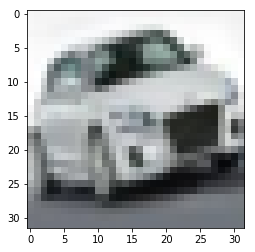

In [119]:
# verify
r = random.randint(0, x_train.shape[0]-1)
plt.imshow(x_train[r].reshape(img_dims))
plt.show()

#### Augment training data with rotations and flips

In [27]:
# Run this after creating a clean augmented_images/ directory. 

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=[0.5, 1],
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True)

datagen.fit(x_train)

i = 0

for batch in datagen.flow(x_train, 
                          batch_size=256, 
                          save_to_dir='/Users/vwr/augmented_images/',
                          save_prefix='car',
                          save_format='jpeg'):
    i += 1
    if i > 20:
        break # otherwise the generator would loop indefinitely

In [63]:
from image_utils import get_images_train

augmented_car_train = get_images_train('augmented_car_train.npy', 
                             train_dir = '/Users/vwr/augmented_images/',
                             refresh=True)

Fetching and processing images from directory:  /Users/vwr/augmented_images/
Saved training data into:  augmented_car_train.npy
Shape of training data: (5256, 32, 32, 3)


#### Create final training data

In [64]:
car_train = np.concatenate((x_train, augmented_car_train), axis = 0)
print(car_train.shape)

(10256, 32, 32, 3)


## Convolutional encoder + Dense decoder

In [66]:
from keras.layers import Reshape
from keras.optimizers import Adam

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))

# build the network
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2,), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder
decoded = Flatten()(encoded)
decoded = Dense(3072, activation="sigmoid")(decoded)
decoded = Reshape((IMG_SIZE, IMG_SIZE, NUM_CHANNELS))(decoded)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(lr=0.0012), loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
__________

In [68]:

# train
autoencoder.fit(car_train, car_train,
                epochs=60,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/60
10256/10256 [==============================] - 22s - loss: 0.5320    
Epoch 2/60
10256/10256 [==============================] - 24s - loss: 0.5318    
Epoch 3/60
10256/10256 [==============================] - 24s - loss: 0.5323    
Epoch 4/60
10256/10256 [==============================] - 23s - loss: 0.5318    
Epoch 5/60
10256/10256 [==============================] - 24s - loss: 0.5317    
Epoch 6/60
10256/10256 [==============================] - 24s - loss: 0.5316    
Epoch 7/60
10256/10256 [==============================] - 23s - loss: 0.5313    
Epoch 8/60
10256/10256 [==============================] - 23s - loss: 0.5314    
Epoch 9/60
10256/10256 [==============================] - 23s - loss: 0.5314    
Epoch 10/60
10256/10256 [==============================] - 24s - loss: 0.5312    
Epoch 11/60
10256/10256 [==============================] - 25s - loss: 0.5310    
Epoch 12/60
10256/10256 [==============================] - 25s - loss: 0.5311    
Epoch 13/60
10256/10256 [

#### (Optional) Save model

In [71]:
autoencoder.save("0.52392_car_convolutional_autoencoder")


### How well does it generalize to the test set?

In [69]:
decoded_imgs = autoencoder.predict(x_test)

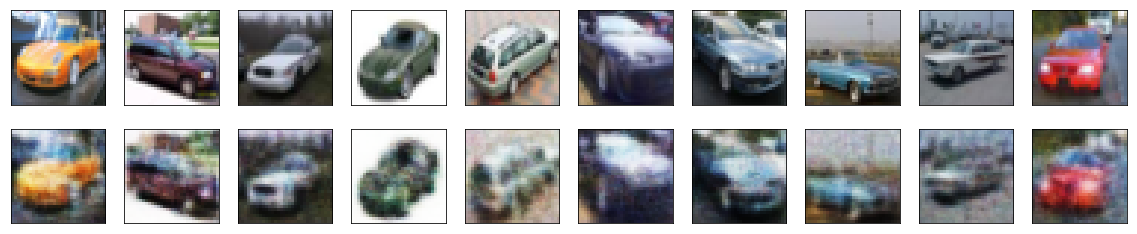

In [76]:
n = 10  # the number of panels to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # 50
    index = i + 140
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Visualizing the layers/filters

### Using the representation to classify cars - transfer learning

In [152]:
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
model_base = load_model("0.52392_car_convolutional_autoencoder")
# Freeze layers of the base model (our trained encoder)
for layer in model_base.layers:
    layer.trainable = False
x = model_base.get_layer('conv3').output
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(encoded)
x = Dense(1, activation='sigmoid')(x)

classifier = Model(model_base.input, x)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 4, 4, 128)         0         
__________

In [352]:

# train
classifier.fit(full_x_train, full_y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/50
9500/9500 [==============================] - 4s - loss: 0.2011 - acc: 0.9218     
Epoch 2/50
9500/9500 [==============================] - 4s - loss: 0.2024 - acc: 0.9214     
Epoch 3/50
9500/9500 [==============================] - 4s - loss: 0.2011 - acc: 0.9216     
Epoch 4/50
9500/9500 [==============================] - 4s - loss: 0.2015 - acc: 0.9215     
Epoch 5/50
9500/9500 [==============================] - 4s - loss: 0.2006 - acc: 0.9216     
Epoch 6/50
9500/9500 [==============================] - 5s - loss: 0.2007 - acc: 0.9214     
Epoch 7/50
9500/9500 [==============================] - 5s - loss: 0.1999 - acc: 0.9228     
Epoch 8/50
9500/9500 [==============================] - 5s - loss: 0.2008 - acc: 0.9224     
Epoch 9/50
9500/9500 [==============================] - 4s - loss: 0.2001 - acc: 0.9231     
Epoch 10/50
9500/9500 [==============================] - 5s - loss: 0.1991 - acc: 0.9217     
Epoch 11/50
9500/9500 [==============================] - 5s - loss: 0

In [232]:
predictions = classifier.predict(x_test)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print(predictions.shape)

(10000, 1)


[ 1.]


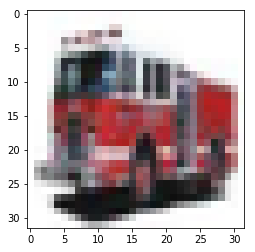

In [351]:
ind = random.randint(0, 10000)
print(predictions[ind])
plt.imshow(x_test[ind])
plt.show()